In [112]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import outlier_removal as out
from sklearn import linear_model


## helpful functions:
### correlated columns
To find, for a given column, another column with the highest possible correlation

In [301]:
def find_cor(name,df):
    cor=df.corr()
    index=df.columns.get_loc(name)
    if(index>2):#Dates fall out, to be corrected when we have dates
        index=index-3
    cor=cor[name]
    c=[np.abs(e) for e in cor]
    c[index]=0 # highsest correltion is with it self
    max_cor=max(c)
    print(max_cor)
    max_cor_index=c.index(max_cor)
    if( max_cor_index>2):
        max_cor_index=max_cor_index+3 # Dates fall out, calculate dataframe index
    max_cor_name=df.columns[max_cor_index]
    print(max_cor_name)
    return max_cor_name

### Linear 1D fit

In [309]:
def lin_regr(namex,namey):
    model = linear_model.LinearRegression()
    nansx= np.array(np.isnan(df[namex]))
    nansy= np.array(np.isnan(df[namey]))
    nan=np.logical_or(nansx,nansy)
    df_nonans=df[np.logical_not(nan)]
    x=df_nonans[namex].values
    x=[e for e in x]
    x=np.array(x)
    y=df_nonans[namey].values
    y=[e for e in y]
    y=np.array(y)
    model.fit(x[:, np.newaxis], y)
    res= model.coef_
    print("we estimate y= ax+b, with a equals:"+ str(res))
    return res

### Outliers visualization

In [323]:
def vis_and_return_Outl(df,column,factor_iqr):
    df.boxplot(column,return_type='dict',whis=factor_iqr)
    plt.title('outliers')
    y=df[column]
    x=range(1, len(y)+1)
    plt.figure()
    plt.title(column+ " plottet against random")
    plt.plot(x,y,'.')
    #quartiles
    Q1=np.percentile(df.dropna()[column],25)
    Q3=np.percentile(df.dropna()[column],75)
    iqr=Q3-Q1
    
    #identify outliers
    mean=np.mean(df[column])
    index=np.logical_or(df[column]< Q1 - factor_iqr*iqr, df[column]> Q3 + factor_iqr*iqr)
    outliers=df[index]
    return outliers
    

# The Actual Data Cleaning


In [324]:
df=pd.read_csv('TrainSample2.csv',sep=';' )

We select only those 363 lines, that do not have the group of 18 featrues missing

In [325]:
df=df[~ np.logical_and(np.isnan(df['Shot_Total']), np.isnan(df['Frac_Gradient (PSI/ft)'])  )] ## remove 97 lines with 18 missing
len(df)


363

## ShutInPressure_Fil (KPa)
We check  missing values ( apart from the 97 we extracted already)

In [326]:
missing= np.isnan(df['ShutInPressure_Fil (KPa)'])
sum(missing)


31

We verify that these 31 lines are not a pattern. We find out that there is a high correlation with ShutInPressure_Initial. As the latter has just 1 missing value the same lines, we can ShutInPressure_Fil with ShutInPressure_Initial using linear regression.

So we can try a linear fit with our customzed function:

In [327]:
a=lin_regr(find_cor('ShutInPressure_Fil (KPa)',df),'ShutInPressure_Fil (KPa)')
m1=np.mean(df['ShutInPressure_Initial (KPa)'])
m2=np.mean(df['ShutInPressure_Fil (KPa)'])
df['ShutInPressure_Fil (KPa)'][missing]=(df['ShutInPressure_Initial (KPa)'][missing]- m1)*a+ m2
df['ShutInPressure_Initial (KPa)'][missing]

0.709788959854
ShutInPressure_Initial (KPa)
we estimate y= ax+b, with a equals:[ 0.66924334]


8      1.981787
22    -1.678896
27     1.126918
45     0.540059
46     0.131891
99     0.050392
114    0.918099
153    0.019502
180    0.648880
186         NaN
189    0.112968
190    0.600586
223    2.091678
256   -0.049639
257   -2.435179
295    0.026355
308    0.712157
321    0.854188
326    0.279104
348    0.401689
361    0.487605
363    1.135837
368   -0.403652
375   -0.767063
392    0.010256
434    1.798313
438   -0.875424
447    0.788128
448    0.878624
453   -0.305628
454    0.967420
Name: ShutInPressure_Initial (KPa), dtype: float64

we could not estimate one value as its missing in ShutInPressure_Initial as well. So we have to replace it with the mean.

In [328]:
df['ShutInPressure_Fil (KPa)'][np.isnan(df['ShutInPressure_Fil (KPa)'])]=m2


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [329]:
df['ShutInPressure_Fil (KPa)'][np.isnan(df['ShutInPressure_Fil (KPa)'])]

Series([], Name: ShutInPressure_Fil (KPa), dtype: float64)

now we have no more missing values. make scatter plot to check how the estimation was.

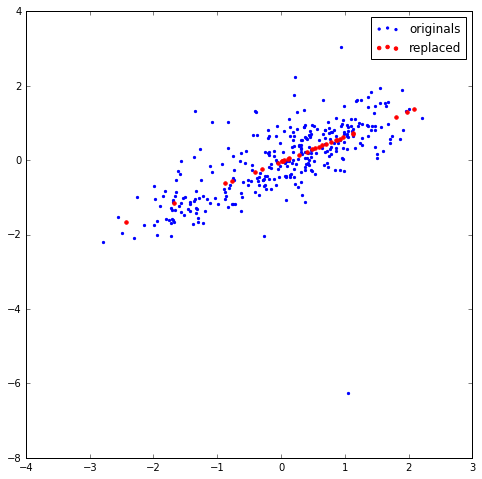

In [330]:
plt.figure(figsize=(8,8))
plt.scatter(df['ShutInPressure_Initial (KPa)'][~missing],df['ShutInPressure_Fil (KPa)'][~missing],color='blue',s=5,label='originals')
plt.scatter(df['ShutInPressure_Initial (KPa)'][missing],df['ShutInPressure_Fil (KPa)'][missing],color='red',s=12,label='replaced')
plt.legend()


### Outliers
we use our customzied function "replOut" ( import outlier_removal.py)

,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
298,169,-0.361700,0.934645,13/02/14,24/08/14,21/10/14,-0.098057,-1.130276,-0.687802,-0.481296,...,0.277007,3.052486,0.936939,0.349276,1.627854,0.181738,0.115375,-0.177129,1.518204,-0.170041
340,456,0.280183,-0.135503,12/05/13,27/10/13,20/12/13,1.483162,-0.176755,-0.829416,0.404333,...,0.186816,-6.253073,1.056170,0.858999,-0.988721,0.591386,-0.761109,-0.152933,1.153736,-0.419644


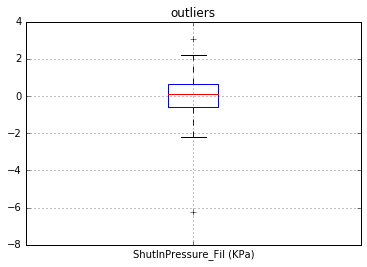

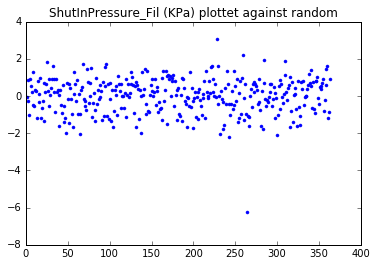

In [331]:
outs=vis_and_return_Outl(df,"ShutInPressure_Fil (KPa)",1.5)
outs

We decide to only replace the bigger outlier (API =340). As it seems not to be an outlier in ShutInPressure_Initial, we can do the 
same as with the missing values. We still have that parameter from above.

In [332]:
df['ShutInPressure_Fil (KPa)'][340]=(df['ShutInPressure_Initial (KPa)'][340]- m1)*a+ m2
df['ShutInPressure_Fil (KPa)'][340]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.66991271638831218

## ShutInPressure_Initial
lets see how many missing values

In [333]:
missing= np.isnan(df['ShutInPressure_Initial (KPa)'])
sum(missing)

6

lets look for correlated columns

In [334]:
find_cor('ShutInPressure_Initial (KPa)',df)

0.792988539771
ShutInPressure_Fil (KPa)


'ShutInPressure_Fil (KPa)'

its the other way round as before (and even more because we did the linear regression before). We know from before, that the two coumns have ( apart from the exreacted 97 lines) only one missing line im comon, which we estimated by the mean before. Hence we can use linear regression to estimate the missing vals the other way round also. we just have to swap their places in the code from above. the new a is now 1/old_a

In [335]:
b=lin_regr(find_cor('ShutInPressure_Initial (KPa)',df),'ShutInPressure_Initial (KPa)')
m1=np.mean(df['ShutInPressure_Fil (KPa)'])
m2=np.mean(df['ShutInPressure_Initial (KPa)'])
df['ShutInPressure_Initial (KPa)'][missing]=(df['ShutInPressure_Fil (KPa)'][missing]- m1)*a+ m2
df['ShutInPressure_Initial (KPa)'][missing]

0.792988539771
ShutInPressure_Fil (KPa)
we estimate y= ax+b, with a equals:[ 0.91491078]


50    -0.579655
68     0.891261
107   -0.465378
135    0.234524
186    0.019960
249    0.069201
Name: ShutInPressure_Initial (KPa), dtype: float64

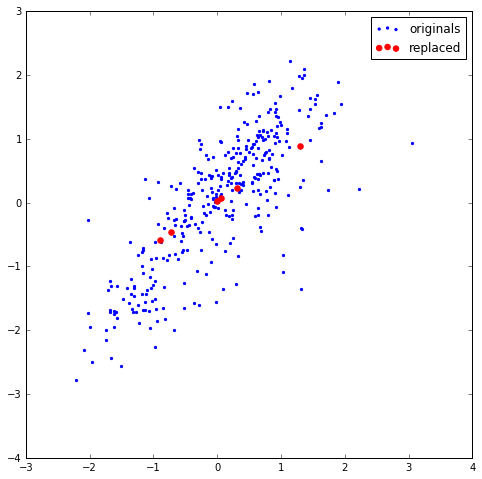

In [342]:
plt.figure(figsize=(8,8))
plt.scatter(df['ShutInPressure_Fil (KPa)'][~missing],df['ShutInPressure_Initial (KPa)'][~missing],color='blue',s=5,label='originals')
plt.scatter(df['ShutInPressure_Fil (KPa)'][missing],df['ShutInPressure_Initial (KPa)'][missing],color='red',s=30,label='replaced')
plt.legend()

Its a bit weird, that the slope of the linear fit before is not 1 over the one we have now, but this might be due to the squared error regression and the outliers 
### to be checked

## 
We see that we have just one. But looking at the plot, we see that it is not a huge outlier. we decide to leave it,

,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
312,585,2.191754,-1.461372,29/10/12,15/11/12,28/03/13,-1.295328,0.52743,1.046354,-0.240118,...,0.932451,-2.210476,-2.784977,-2.767494,0.667339,-0.56075,-0.556775,2.455301,-0.861051,-0.812057


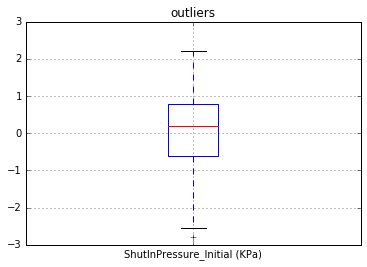

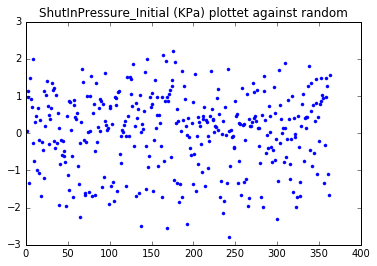

In [346]:
out2=vis_and_return_Outl(df,"ShutInPressure_Initial (KPa)",1.5)
out2